In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from math import sqrt, log, inf
import random

import pylab 
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 7.5)})

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.optimize import minimize

In [2]:
data = pd.read_csv('SeoulBikeData.csv', encoding='unicode_escape')
data = data.drop(['Date'], axis=1)

A = data.drop(['Rented Bike Count'], axis=1)
y = data['Rented Bike Count']

A_train, A_test, y_train, y_test = train_test_split(A, y, test_size=0.3, random_state=123)

quali = ['Seasons', 'Holiday', 'Functioning Day']
quanti = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 
          'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

In [3]:
columns = A_train.columns
ord_enc = OrdinalEncoder()

for feature in quali:
    ord_enc.fit(A_train[[feature]])
    A_train[feature] = ord_enc.transform(A_train[[feature]])
    A_test[feature] = ord_enc.transform(A_test[[feature]])
    
A_scaler = StandardScaler()
A_scaler.fit(A_train)
A_train = pd.DataFrame(A_scaler.transform(A_train), columns=columns)
A_test = pd.DataFrame(A_scaler.transform(A_test), columns=columns)

y_scaler = StandardScaler()
y_scaler.fit(y_train.values.reshape(-1, 1))
y_train = pd.DataFrame(y_scaler.transform(y_train.values.reshape(-1, 1)), columns=['Rented Bike Count'])['Rented Bike Count']
y_test = pd.DataFrame(y_scaler.transform(y_test.values.reshape(-1, 1)), columns=['Rented Bike Count'])['Rented Bike Count']

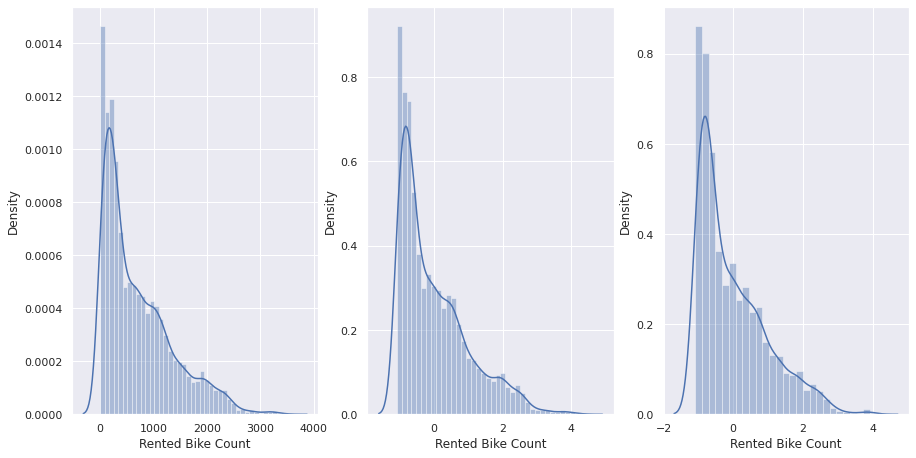

In [4]:
fig, ax = plt.subplots(1, 3)

for i in range(3):
    if i == 0:
        sns.distplot(data['Rented Bike Count'], ax=ax[i])
    elif i == 1:
        sns.distplot(y_train, ax=ax[i])
    else:
        sns.distplot(y_test, ax=ax[i])

Text(0.5, 1.0, 'Correlation Matrix')

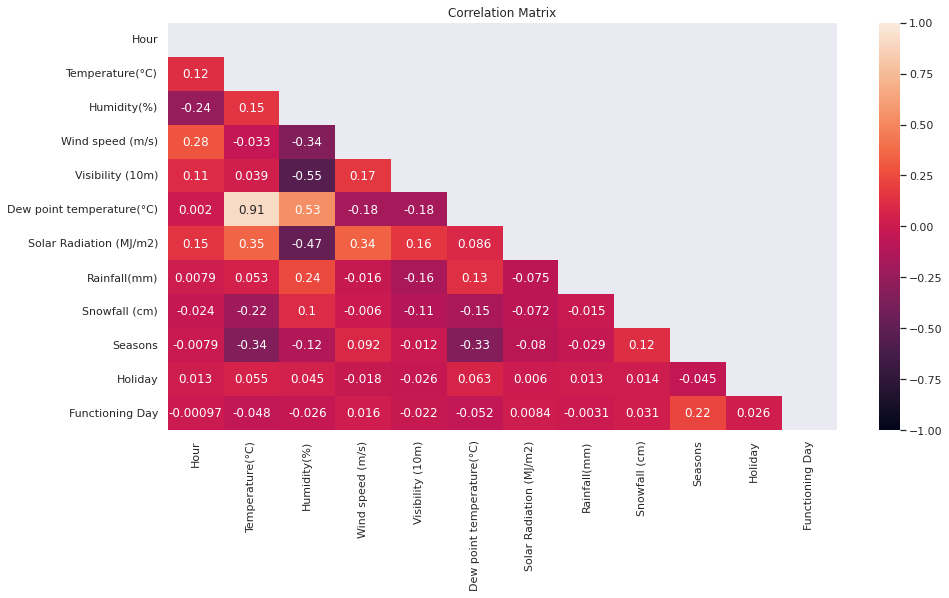

In [5]:
mask = np.triu(np.ones_like(A_train.corr(), dtype=np.bool))
heatmap = sns.heatmap(A_train.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
plt.title('Correlation Matrix')

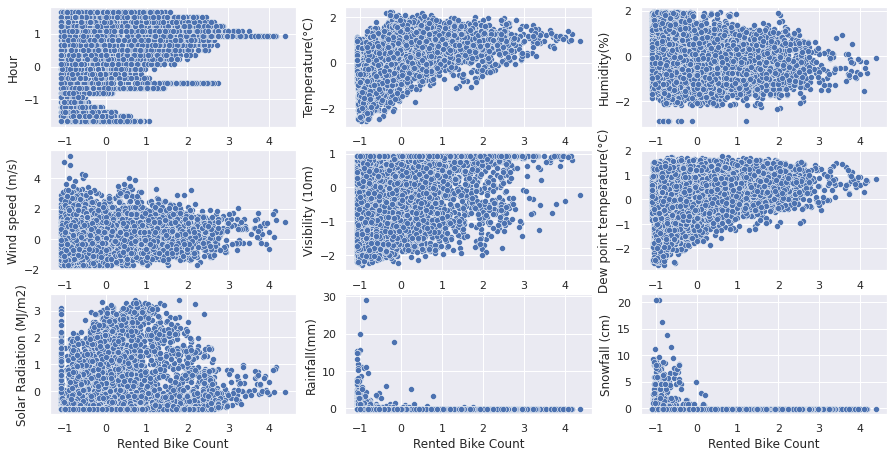

In [6]:
# TODO: display each features compared to y
fig, ax = plt.subplots(3, 3)
count = 0

for i in range(3):
    for j in range(3):
        sns.scatterplot(ax=ax[i, j], x=y_train, y=A_train[quanti[count]])
        count += 1

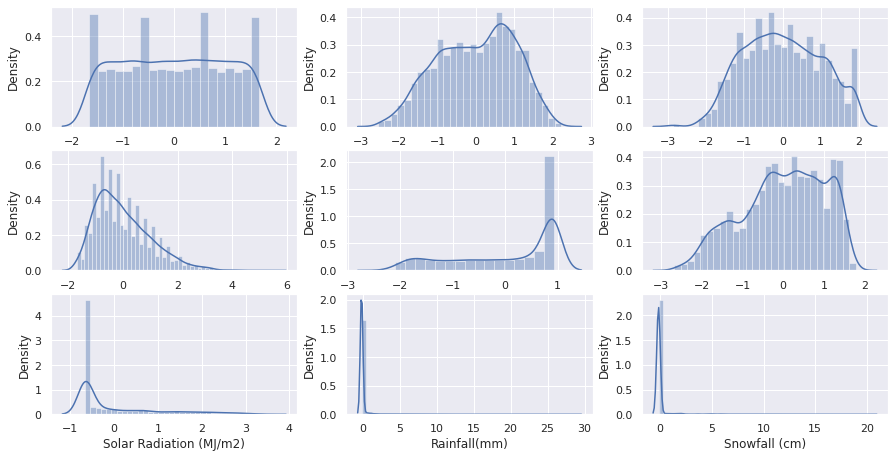

In [7]:
fig, ax = plt.subplots(3, 3)
count = 0

for i in range(3):
    for j in range(3):
        sns.distplot(A_train[quanti[count]], ax=ax[i, j])
        count += 1

Text(0, 0.5, 'PC2')

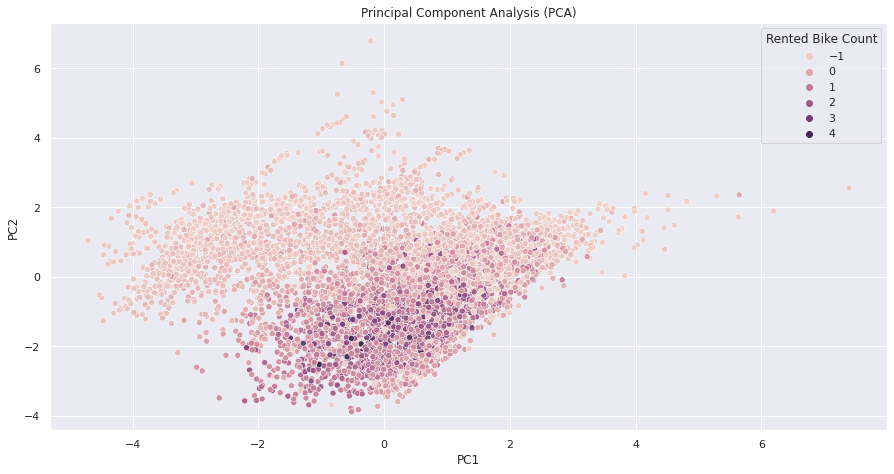

In [8]:
pca_A = PCA().fit_transform(A_train)
sns.scatterplot(x=pca_A[:,0], y=pca_A[:,1], hue=y_train)
plt.title('Principal Component Analysis (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [9]:
# Parameters
n = len(A_train)
d = A_train.shape[1]
x0 = np.zeros(d)

epochs = 1000

A_train = np.array(A_train)
A_test = np.array(A_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
def relative_error(x):
    r1 = np.linalg.norm(A_test.dot(x) - y_test)
    r2 = np.linalg.norm(y_test)
    return r1 / r2

Relative prediction error: 0.6770020701243112


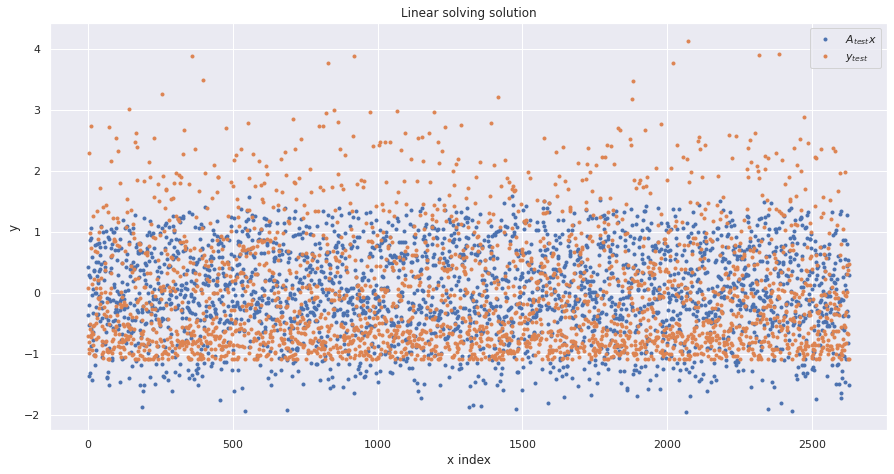

In [11]:
x = np.linalg.inv(A_train.T.dot(A_train)).dot(A_train.T.dot(y_train))

plt.plot(A_test.dot(x), '.')
plt.plot(y_test, '.' )
plt.legend(('$A_{test} x$', '$y_{test}$'))
plt.title('Linear solving solution')
plt.xlabel('x index')
plt.ylabel('y')

linear = relative_error(x)
print(f'Relative prediction error: {linear}')

In [12]:
def loss_function(x, which='train'): 
    if which == 'train':
        loss = (1/2) * np.linalg.norm(A_train.dot(x) - y_train)**2
    elif which == 'test':
        loss = (1/2) * np.linalg.norm(A_test.dot(x) - y_test)**2
        
    return loss


def grad(x): 
    return A_train.T.dot(A_train.dot(x) - y_train)


def hess(): 
    return A_train.T.dot(A_train)


def step_choice(choice, k):
    if choice[0] == 'x/L':
        L = (np.linalg.norm(A_train.T.dot(A_train)))
        step = choice[1]/L
    elif choice[0] == 'x/sqrt(k+1)':
        step = choice[1]/sqrt(k+1)
        
    return step


def armijo(xk, dk, w=1e-4, p0=1, tau=0.25):
    k = 0
    pk = p0
    while loss_function(xk + pk * dk) > loss_function(xk) + w * pk * np.vdot(grad(xk), dk):
        pk = tau * pk
        k += 1

    return pk


def calculate_loss_val(loss_vals, xk):
    loss = loss_function(xk)
    loss_vals.append(np.linalg.norm(loss - best_min))
    
    return loss_vals

In [13]:
def gd(epochs, x0, step):
    xk = x0

    loss_vals = []
    loss_vals = calculate_loss_val(loss_vals, x0)
    
    for k in range(epochs):
        tau = step_choice(step, k)
        xk = xk - tau * grad(xk)
        loss_vals = calculate_loss_val(loss_vals, xk)
        
    return loss_vals, xk


def gd_armijo(epochs, x0):
    xk = x0
    loss_vals = []
    loss_vals = calculate_loss_val(loss_vals, x0)
    
    for k in range(epochs):
        dk = -grad(xk)
        tau = armijo(xk, dk)
        xk = xk + tau * dk
        loss_vals = calculate_loss_val(loss_vals, xk)
        
    return loss_vals, xk

In [14]:
# calculate good minimizer
bfgs = minimize(loss_function, x0, method='BFGS', jac=grad)
best_min = bfgs.fun

Text(0, 0.5, 'Objective - log scale')

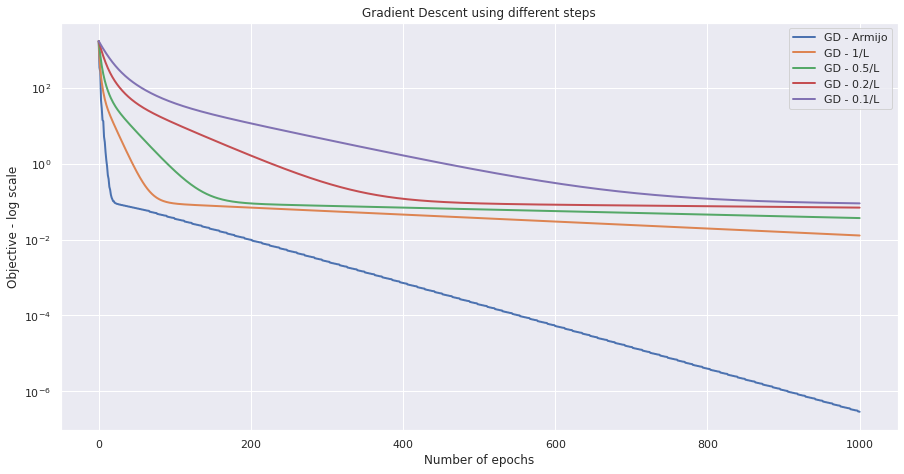

In [15]:
steps = [1, 1/2, 1/5, 1/10]

loss_vals, xk = gd_armijo(epochs, x0)
label = "GD - Armijo"
plt.plot(loss_vals, label=label, lw=2)

for x in steps:
    loss_vals, xk = gd(epochs, x0, ('x/L', x))
    label = f"GD - {x}/L"
    plt.plot(loss_vals, label=label, lw=2)

plt.yscale('log')
plt.legend()
plt.title('Gradient Descent using different steps')
plt.xlabel('Number of epochs')
plt.ylabel('Objective - log scale')

In [16]:
def nesterov(epochs, x0, step):
    xk = x0
    xkp1 = x0
    zk = x0
    tk = 0
    tkp1 = 1
    momentum = 0

    loss_vals = []
    loss_vals = calculate_loss_val(loss_vals, x0)
    
    for k in range(epochs):
        tau = step_choice(step, k)
        xk1 = zk - tau * grad(zk)
        
        zk = xk1 + momentum * (xk1 - xk)
        xk = xk1
        tk1 = 0.5 * (1 + sqrt(1 + 4 * (tk**2)))
        momentum = (tk-1)/tk1
        tk = tk1
        
        loss_vals = calculate_loss_val(loss_vals, xk)
        
    return loss_vals, xk

Text(0, 0.5, 'Objective - log scale')

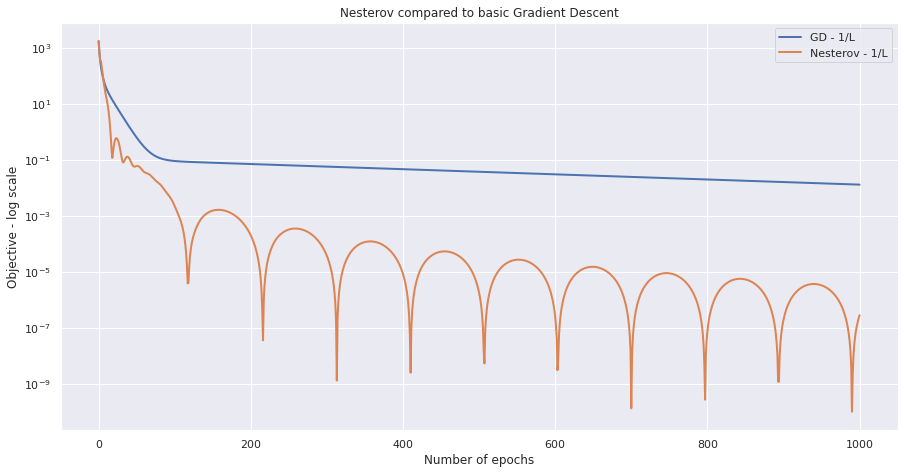

In [17]:
loss_vals, xk = gd(epochs, x0, ('x/L', 1))
plt.plot(loss_vals, label="GD - 1/L", lw=2)

loss_vals, xk = nesterov(epochs, x0, ('x/L', 1))
label = "Nesterov - 1/L"
plt.plot(loss_vals, label=label, lw=2)

plt.yscale('log')
plt.legend()
plt.title('Nesterov compared to basic Gradient Descent')
plt.xlabel('Number of epochs')
plt.ylabel('Objective - log scale')

In [18]:
def polak_ribiere(epochs, x0):
    xk = x0
    dk = -grad(x0)
    
    loss_vals = []
    loss_vals = calculate_loss_val(loss_vals, x0)
    
    for k in range(epochs): 
        tau = armijo(xk, dk)
        xk1 = xk + tau * dk
        Bk = np.vdot(grad(xk1), grad(xk1) - grad(xk)) / np.linalg.norm(grad(xk))**2
        dk = -grad(xk) + np.dot(Bk, dk)
        xk = xk1
        loss_vals = calculate_loss_val(loss_vals, xk)
        
    return loss_vals, xk


def newton(epochs, x0):
    xk = x0
    
    loss_vals = []
    loss_vals = calculate_loss_val(loss_vals, x0)

    for k in range(epochs): 
        dk = -np.dot(np.linalg.inv(hess()), grad(xk))
        xk = xk + dk
        loss_vals = calculate_loss_val(loss_vals, xk)
        
    return loss_vals, xk

Text(0, 0.5, 'Objective - log scale')

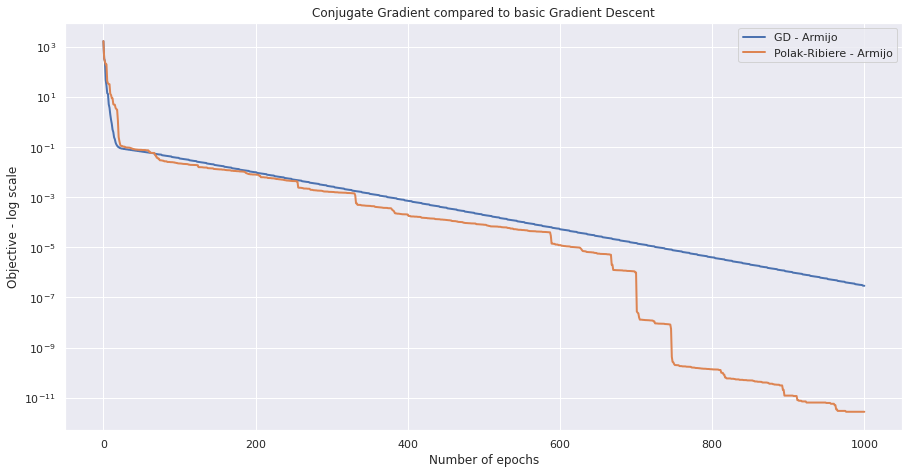

In [19]:
loss_vals, xk = gd_armijo(epochs, x0)
plt.plot(loss_vals, label="GD - Armijo", lw=2)

loss_vals, xk = polak_ribiere(epochs, x0)
label = "Polak-Ribiere - Armijo"
plt.plot(loss_vals, label=label, lw=2)

plt.yscale('log')
plt.legend()
plt.title('Conjugate Gradient compared to basic Gradient Descent')
plt.xlabel('Number of epochs')
plt.ylabel('Objective - log scale')

In [20]:
loss_vals, xk = newton(epochs, x0)
print(loss_vals[0:5])

[1692.9104692912567, 0.0, 0.0, 0.0, 0.0]


In [21]:
def grad_i(x, i):
    A = A_train[i]
    y = y_train[i]
    grad = A.T.dot(A.dot(x) - y)
    return grad


def sg(epochs, x0, batch_size, step):
    indexes = [i for i in range(n)]
    xk = x0
    
    loss_vals = []
    loss_vals = calculate_loss_val(loss_vals, x0)
    
    for k in range(epochs):
        for _ in range(int(n/batch_size)):
            tau = step_choice(step, k)
            ik = random.sample(indexes, batch_size)
            
            grad = np.zeros(d)
            for i in ik:
                grad += grad_i(xk, i)
                
            grad = grad / len(ik)
            xk = xk - tau * grad
            
        loss_vals = calculate_loss_val(loss_vals, xk)
        
    return loss_vals, xk

Text(0, 0.5, 'Objective - log scale')

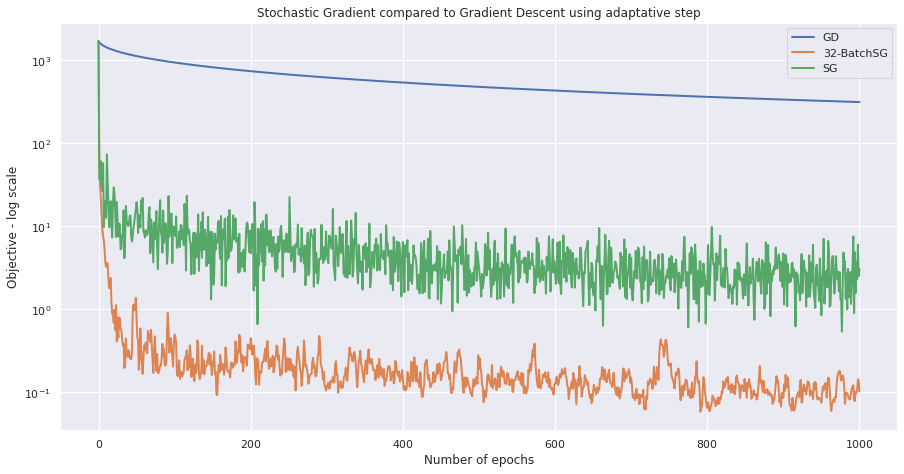

In [22]:
step = 1/100

loss_vals, xk = sg(epochs, x0, n, ('x/sqrt(k+1)', step))
plt.plot(loss_vals, label="GD", lw=2)

loss_vals, xk = sg(epochs, x0, 32, ('x/sqrt(k+1)', step))
plt.plot(loss_vals, label="32-BatchSG", lw=2)

loss_vals, xk = sg(epochs, x0, 1, ('x/sqrt(k+1)', step))
plt.plot(loss_vals, label="SG", lw=2)

plt.yscale('log')
plt.legend()
plt.title('Stochastic Gradient compared to Gradient Descent using adaptative step')
plt.xlabel('Number of epochs')
plt.ylabel('Objective - log scale')

Text(0, 0.5, 'Objective - log scale')

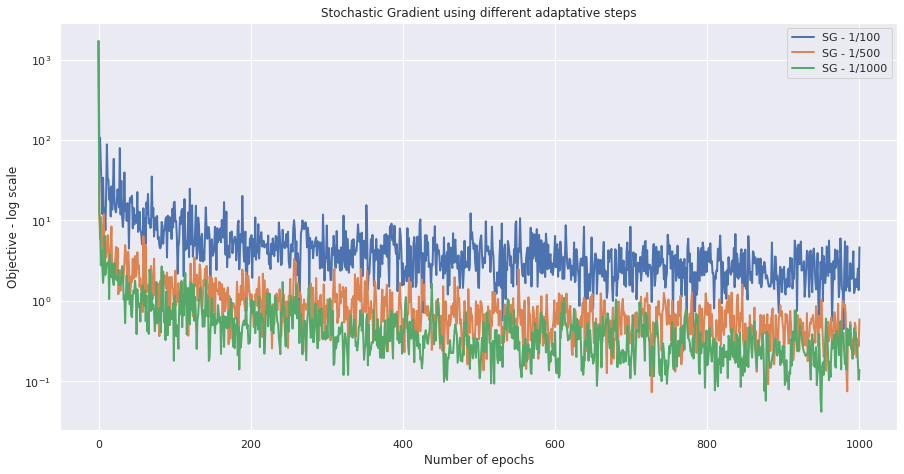

In [23]:
loss_vals, xk = sg(epochs, x0, 1, ('x/sqrt(k+1)', 1/100))
plt.plot(loss_vals, label="SG - 1/100", lw=2)

loss_vals, xk = sg(epochs, x0, 1, ('x/sqrt(k+1)', 1/500))
plt.plot(loss_vals, label="SG - 1/500", lw=2)

loss_vals, xk = sg(epochs, x0, 1, ('x/sqrt(k+1)', 1/1000))
plt.plot(loss_vals, label="SG - 1/1000", lw=2)

plt.yscale('log')
plt.legend()
plt.title('Stochastic Gradient using different adaptative steps')
plt.xlabel('Number of epochs')
plt.ylabel('Objective - log scale')

The best lambda is 46.47


Text(0.5, 1.0, 'Ridge Regularization')

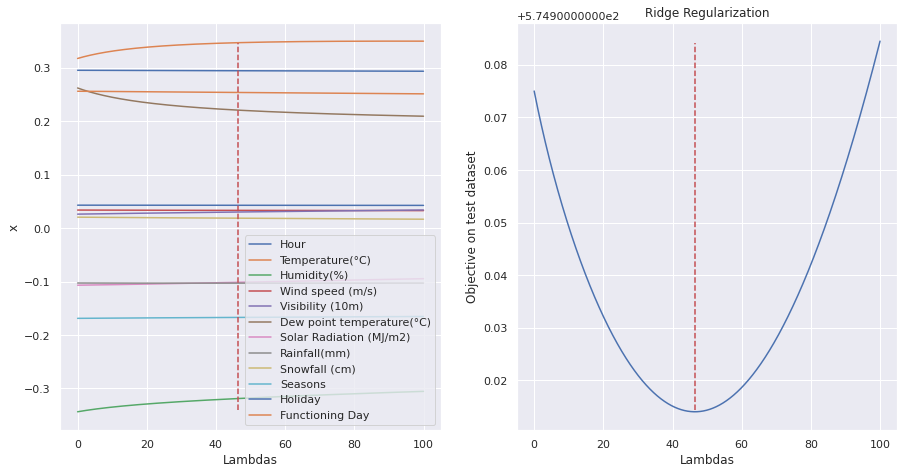

In [24]:
min_loss = inf
best_ridge_lambda = inf
coefs = []
losses = []
ridge_lambdas = np.arange(0, 100, 0.01)

for ridge_lambda in ridge_lambdas:
    x = np.linalg.inv(A_train.T.dot(A_train) + ridge_lambda*np.eye(d)).dot(A_train.T.dot(y_train))
    loss = loss_function(x, which='test')
    coefs.append(x)
    losses.append(loss)
    if loss < min_loss:
        min_loss = loss
        best_ridge_lambda = ridge_lambda
    
print(f'The best lambda is {best_ridge_lambda}')

fig, ax = plt.subplots(1, 2)
ax[0].plot(ridge_lambdas, coefs)
ax[0].legend(A.columns)
ax[0].axvline(x=best_ridge_lambda, color='r', linestyle='--', ymin=0.05, ymax=0.95)
ax[0].set_xlabel('Lambdas')
ax[0].set_ylabel('x')
ax[1].plot(ridge_lambdas, losses)
ax[1].axvline(x=best_ridge_lambda, color='r', linestyle='--', ymin=0.05, ymax=0.95)
ax[1].set_xlabel('Lambdas')
ax[1].set_ylabel('Objective on test dataset')

plt.title('Ridge Regularization')

In [25]:
def soft_thresholding(x, s): return np.maximum(abs(x)-s, np.zeros(x.shape)) * np.sign(x)

def ista(epochs, x0, step, Lambda):
    xk = x0
    loss_vals = []
    loss_vals = calculate_loss_val(loss_vals, x0)

    for k in range(epochs):
        tau = step_choice(step, k)
        xk = soft_thresholding(xk - tau * grad(xk), Lambda*tau)
        loss_vals = calculate_loss_val(loss_vals, xk)
        
    return loss_vals, xk

The best lambda is 6.8


Text(0.5, 1.0, 'ISTA - Lasso Regularization')

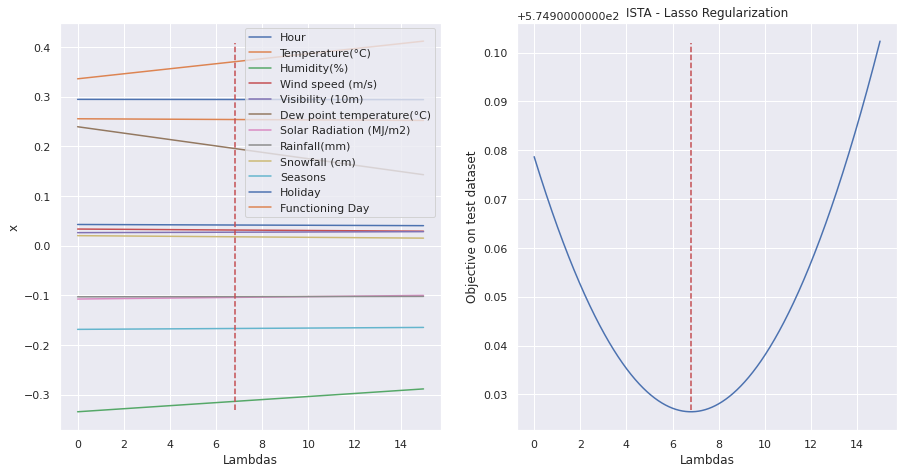

In [26]:
min_loss = inf
best_lasso_lambda = inf
coefs = []
losses = []
lasso_lambdas = np.arange(0, 15, 0.01)

for lasso_lambda in lasso_lambdas:
    loss_vals, xk = ista(epochs, x0, ('x/L', 1), lasso_lambda)
    loss = loss_function(xk, which='test')
    coefs.append(xk)
    losses.append(loss)
    if loss < min_loss:
        min_loss = loss
        best_lasso_lambda = lasso_lambda

print(f'The best lambda is {best_lasso_lambda}')

fig, ax = plt.subplots(1, 2)
ax[0].plot(lasso_lambdas, coefs)
ax[0].legend(A.columns)
ax[0].axvline(x=best_lasso_lambda, color='r', linestyle='--', ymin=0.05, ymax=0.95)
ax[0].set_xlabel('Lambdas')
ax[0].set_ylabel('x')
ax[1].plot(lasso_lambdas, losses)
ax[1].axvline(x=best_lasso_lambda, color='r', linestyle='--', ymin=0.05, ymax=0.95)
ax[1].set_xlabel('Lambdas')
ax[1].set_ylabel('Objective on test dataset')

plt.title('ISTA - Lasso Regularization')